# Severstal : Steel Defect Detection
https://www.kaggle.com/c/severstal-steel-defect-detection/data

Learning U Nets with Tensorflow using Severstal Dataset from Keggle competition

In [21]:
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import os, sys
import csv
from matplotlib import pyplot as plt

In [22]:
test_path = 'test_images'
train_path = 'train_images'

In [23]:
def get_filenames(mypath): 
    return [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

In [24]:
test_filenames = get_filenames(test_path)
train_filenames = get_filenames(train_path) 

In [25]:
print(len(test_filenames))

1801


In [26]:
print(len(train_filenames))

12568


Get training labels / annotations

In [27]:
defects = { r[0] : r[1] for r in [row for row in csv.reader(open('train.csv', 'r'))][1:]}

In [28]:
defects_df = pd.read_csv('train.csv')
defects_df['ImageId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[0])
defects_df['ClassId'] = defects_df['ImageId_ClassId'].apply(lambda x : x.split('_')[1])

In [29]:
defects_df.set_index('ImageId_ClassId', inplace=True)

In [30]:
defects_df.head(25)

EncodedPixels  \
ImageId_ClassId                                                      
0002cc93b.jpg_1  29102 12 29346 24 29602 24 29858 24 30114 24 3...   
0002cc93b.jpg_2                                                NaN   
0002cc93b.jpg_3                                                NaN   
0002cc93b.jpg_4                                                NaN   
00031f466.jpg_1                                                NaN   
00031f466.jpg_2                                                NaN   
00031f466.jpg_3                                                NaN   
00031f466.jpg_4                                                NaN   
000418bfc.jpg_1                                                NaN   
000418bfc.jpg_2                                                NaN   
000418bfc.jpg_3                                                NaN   
000418bfc.jpg_4                                                NaN   
000789191.jpg_1                                                NaN   
000789191.jpg_2                                                NaN   
000789191.jpg_3                                                NaN   
000789191.jpg_4                                                NaN   
0007a71bf.jpg_1                                                NaN   
0007a71bf.jpg_2                                                NaN   
0007a71bf.jpg_3  18661 28 18863 82 19091 110 19347 110 19603 11...   
0007a71bf.jpg_4                                                NaN   
000a4bcdd.jpg_1  37607 3 37858 8 38108 14 38359 20 38610 25 388...   
000a4bcdd.jpg_2                                                NaN   
000a4bcdd.jpg_3                                                NaN   
000a4bcdd.jpg_4                                                NaN   
000f6bf48.jpg_1                                                NaN   

                       ImageId ClassId  
ImageId_ClassId                         
0002cc93b.jpg_1  0002cc93b.jpg       1  
0002cc93b.jpg_2  0002cc93b.jpg       2  
0002cc93b.jpg_3  0002cc93b.jpg       3  
0002cc93b.jpg_4  0002cc93b.jpg       4  
00031f466.jpg_1  00031f466.jpg       1  
00031f466.jpg_2  00031f466.jpg       2  
00031f466.jpg_3  00031f466.jpg       3  
00031f466.jpg_4  00031f466.jpg       4  
000418bfc.jpg_1  000418bfc.jpg       1  
000418bfc.jpg_2  000418bfc.jpg       2  
000418bfc.jpg_3  000418bfc.jpg       3  
000418bfc.jpg_4  000418bfc.jpg       4  
000789191.jpg_1  000789191.jpg       1  
000789191.jpg_2  000789191.jpg       2  
000789191.jpg_3  000789191.jpg       3  
000789191.jpg_4  000789191.jpg       4  
0007a71bf.jpg_1  0007a71bf.jpg       1  
0007a71bf.jpg_2  0007a71bf.jpg       2  
0007a71bf.jpg_3  0007a71bf.jpg       3  
0007a71bf.jpg_4  0007a71bf.jpg       4  
000a4bcdd.jpg_1  000a4bcdd.jpg       1  
000a4bcdd.jpg_2  000a4bcdd.jpg       2  
000a4bcdd.jpg_3  000a4bcdd.jpg       3  
000a4bcdd.jpg_4  000a4bcdd.jpg       4  
000f6bf48.jpg_1  000f6bf48.jpg       1

## Display some train example data

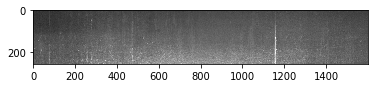

In [31]:
img = cv2.imread(train_path + '/' + defects_df.loc['0007a71bf.jpg_3', 'ImageId'])
#cv2.imshow('train', img)
plt.imshow(img)

In [15]:
img[0]

array([[47, 47, 47],
       [49, 49, 49],
       [49, 49, 49],
       ...,
       [65, 65, 65],
       [67, 67, 67],
       [63, 63, 63]], dtype=uint8)

https://www.kaggle.com/titericz/building-and-visualizing-masks

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

In [34]:
'''
This function is an rle to mask converter.
You supply the rle string for one mask, along with it's height and width
from the solutions for stage1 and it will return the mask.
'''
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height,width), k=1 ) )

In [35]:
img.shape

(256, 1600, 3)

In [19]:
rleToMask = rle2mask(str(defects_df.loc['0007a71bf.jpg_3', 'EncodedPixels']), img.shape)

In [20]:
print(rleToMask.shape)

(256, 1600)


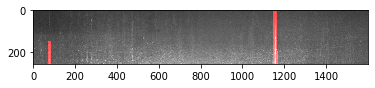

In [21]:
img[rleToMask==1,0] = 255
plt.imshow(img)

## Number of defects per class

In [22]:
defects_df['EncodedPixels'].notnull()

ImageId_ClassId
0002cc93b.jpg_1     True
0002cc93b.jpg_2    False
0002cc93b.jpg_3    False
0002cc93b.jpg_4    False
00031f466.jpg_1    False
                   ...  
ffff4eaa8.jpg_4    False
ffffd67df.jpg_1    False
ffffd67df.jpg_2    False
ffffd67df.jpg_3     True
ffffd67df.jpg_4    False
Name: EncodedPixels, Length: 50272, dtype: bool

In [23]:
defects_df[['ClassId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ClassId']).count()

EncodedPixels
ClassId               
1                  897
2                  247
3                 5150
4                  801

Most common deffect class is 3, then 1, followed by 4 and 2

Are there images with multiple defects? 

In [24]:
image_by_defects = defects_df[['ImageId', 'EncodedPixels']][defects_df['EncodedPixels'].notnull()].groupby(['ImageId']).count().sort_values('EncodedPixels', ascending=False)

In [25]:
image_by_defects.head()

EncodedPixels
ImageId                     
ef24da2ba.jpg              3
db4867ee8.jpg              3
84865746c.jpg              2
5665ada1b.jpg              2
eb44ad79d.jpg              2

In [26]:
image = 'ef24da2ba.jpg' 
df_ = defects_df[defects_df['ImageId'] == image]
df_.head()

EncodedPixels  \
ImageId_ClassId                                                      
ef24da2ba.jpg_1  366699 32 366955 32 367210 33 367466 33 367722...   
ef24da2ba.jpg_2  366338 17 366594 50 366850 82 367106 99 367362...   
ef24da2ba.jpg_3  178369 64 178498 191 178690 255 178946 255 179...   
ef24da2ba.jpg_4                                                NaN   

                       ImageId ClassId  
ImageId_ClassId                         
ef24da2ba.jpg_1  ef24da2ba.jpg       1  
ef24da2ba.jpg_2  ef24da2ba.jpg       2  
ef24da2ba.jpg_3  ef24da2ba.jpg       3  
ef24da2ba.jpg_4  ef24da2ba.jpg       4

In [28]:
# 1 - red, 2 - yellow, 3- green , 4 - blue
colors = {1 : [255, 0, 0], 2: [255, 255, 0], 3: [0, 255, 0], 4: [0, 0, 255]}

## Example of an image with 3 defect classes

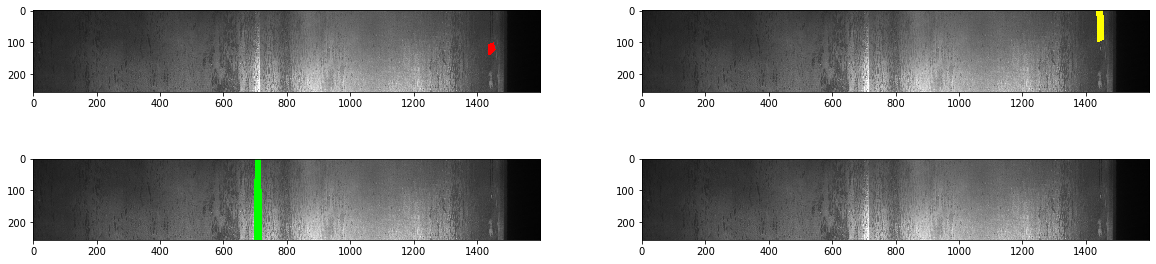

In [34]:
rows=2
columns=2
fig=plt.figure(figsize=(20, 5))
for c_id in range(1, 4+1):
    fig.add_subplot(rows, columns, c_id)
    img = cv2.imread(train_path + '/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    encoded_pixels = df_.loc['{0}_{1}'.format(image, c_id), 'EncodedPixels']
    if str(encoded_pixels) != 'nan':
        rleToMask = rle2mask(encoded_pixels, img.shape)
        img[rleToMask==1] = colors[c_id]
    plt.imshow(img) 
plt.show()

Some more examples

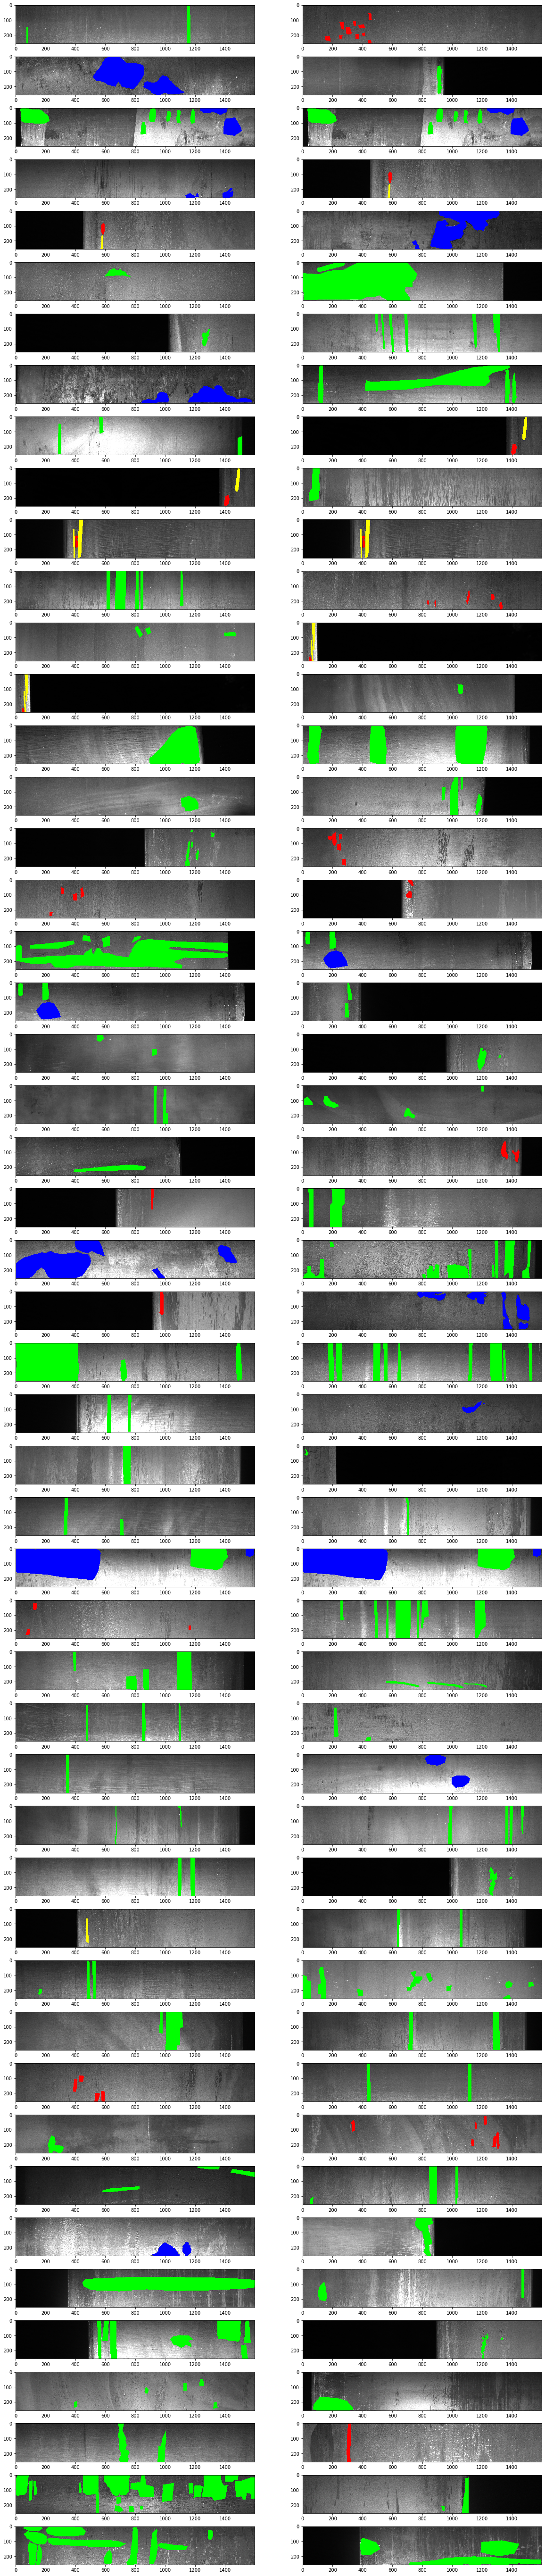

In [32]:
fig=plt.figure(figsize=(20,100))
columns = 2
rows = 50
train = defects_df[defects_df['EncodedPixels'].notnull()]
for i in range(1, 100+1):
    fig.add_subplot(rows, columns, i)
    
    fn = train['ImageId'].iloc[i]
    img = cv2.imread( 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    df = train[train['ImageId'] == fn].reset_index()
    for j in range(len(df)):
        mask = rle2mask( df['EncodedPixels'].iloc[j], img.shape  )
        img[mask==1] = colors[int(df['ClassId'].iloc[j])]
    
    plt.imshow(img)
plt.show()

In [35]:
## Unique images with defects
len(train['ImageId'].unique())

6666

In [ ]:
##save the mapping masks in separate folder

In [48]:
masks = []
for image in train['ImageId'].unique():
    #print(image)
    classes = np.zeros((img.shape[0], img.shape[1]))
    df = train[train['ImageId'] == image].reset_index()
    for j in range(len(df)):
        mask = rle2mask( df['EncodedPixels'].iloc[j], (img.shape[0], img.shape[1])  )
        classes[mask==1] = c_id
    #masks.append(classes)
    np.save(file = f'train_masks/{image}.npy', arr = classes)

In [3]:
test = np.load('train_masks/ef24da2ba.jpg.npy')

In [4]:
test.shape

(256, 1600)

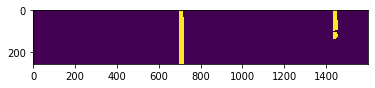

In [5]:
plt.imshow(test)

In [20]:
img.shape

NameError: name 'img' is not defined

## Image segmentation with U-Net

In [17]:
import pix2pix

In [40]:
#define output channels - number of possible classes that one pixel can be assigned to (0 for no defect)
OUTPUT_CHANNELS = 4

In [36]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img.shape, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

/home/magda/projects/severstal-steel-defect-detection/venv/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 3s 0us/step


In [37]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [38]:
def unet_model(output_channels, img_shape):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=img_shape)
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [41]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])